In [46]:
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import pickle
import lz4.frame
from wremnants import plot_tools, scetlib_corrections,theory_tools
from wremnants import boostHistHelpers as hh
from scipy import special
import uproot

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
with lz4.frame.open("/home/k/kelong/work/WRemnants/w_z_gen_dists.pkl.lz4") as minnlof:
    minnlo = pickle.load(minnlof)

In [64]:
minnlo.keys()

dict_keys(['WplusmunuPostVFP', 'WminusmunuPostVFP', 'WplustaunuPostVFP', 'WminustaunuPostVFP', 'ZmumuPostVFP', 'ZtautauPostVFP', 'Zmumu_bugfix_slc7', 'Wminusmunu_bugfix', 'Wminusmunu_bugfix_newprod', 'Wplusmunu_bugfix', 'Wplusmunu_bugfix_reweight_h2'])

In [96]:
minnloWbug = minnlo["WminusmunuPostVFP"]["output"]["nominal_gen"]*minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]/minnlo["WminusmunuPostVFP"]["weight_sum"]
minnlohZbug = minnlo["ZmumuPostVFP"]["output"]["nominal_gen"]*minnlo["ZmumuPostVFP"]["dataset"]["xsec"]/minnlo["ZmumuPostVFP"]["weight_sum"]

minnlohZ = minnlo["Zmumu_bugfix_slc7"]["output"]["nominal_gen"]*2001/minnlo["Zmumu_bugfix_slc7"]["weight_sum"]

minnlohW = (minnlo["Wminusmunu_bugfix_newprod"]["output"]["nominal_gen"]+minnlo["Wminusmunu_bugfix"]["output"]["nominal_gen"])*minnlo["Wminusmunu_bugfix"]["dataset"]["xsec"]/(minnlo["Wminusmunu_bugfix"]["weight_sum"]+minnlo["Wminusmunu_bugfix_newprod"]["weight_sum"])


In [87]:
print(minnlo["Wplusmunu_bugfix"]["dataset"]["xsec"])
print(minnlo["WplusmunuPostVFP"]["dataset"]["xsec"])
print(minnlo["Zmumu_bugfix_slc7"]["dataset"]["xsec"])

11765.9
11572.19
1976.1


In [93]:
minnlohW.sum()


WeightedSum(value=8641.28, variance=3.0687)

In [6]:
scetlibhZ_tot = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Z/inclusive_Z.npz", add_nonsing=False)
scetlibhZ_A4 = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/inclusive_Z_pT_A4.npz", add_nonsing=False, flip_y_sign=True)

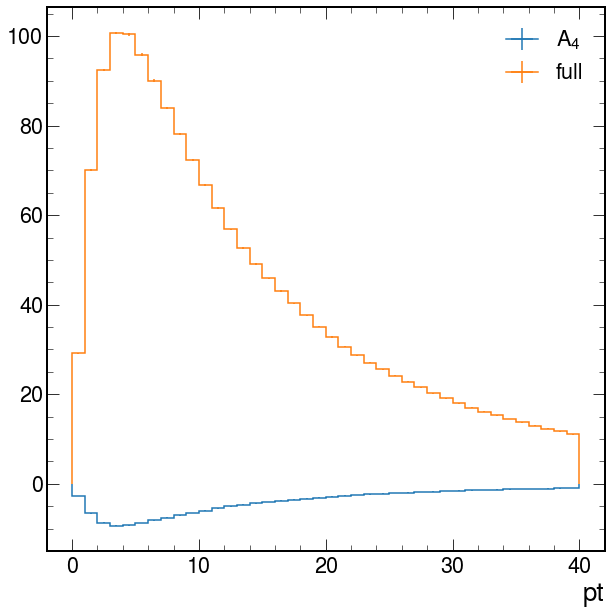

In [7]:
scetlibhZ_A4.project("pt").plot(label="A$_{4}$")
scetlibhZ_tot.project("pt").plot(label="full")
plt.legend()

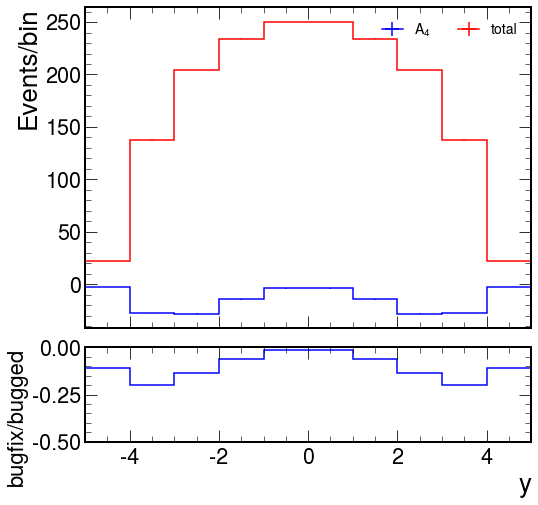

In [8]:
fig = plot_tools.makePlotWithRatioToRef([scetlibhZ_tot.project("y"), scetlibhZ_A4.project("y")], xlim=[-5, 5],colors=["red", "blue",], labels=["total", "A$_{4}$"], rrange=[-0.5, 0], binwnorm=1.)

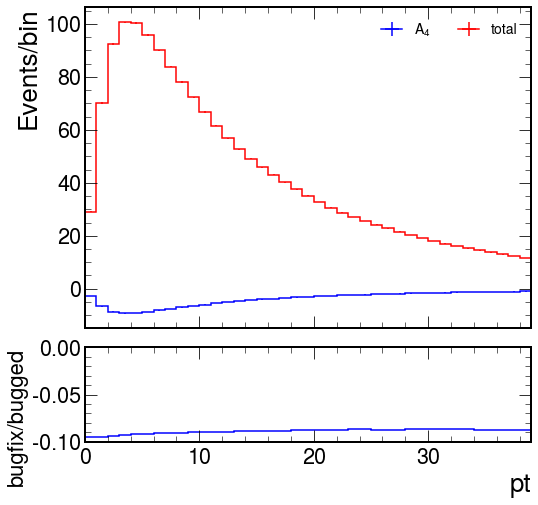

In [9]:
fig = plot_tools.makePlotWithRatioToRef([scetlibhZ_tot.project("pt"), scetlibhZ_A4.project("pt")],colors=["red", "blue",], labels=["total", "A$_{4}$"], rrange=[-0.1, 0], binwnorm=1.)

In [10]:
s = hist.tag.Slicer()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0482864700>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

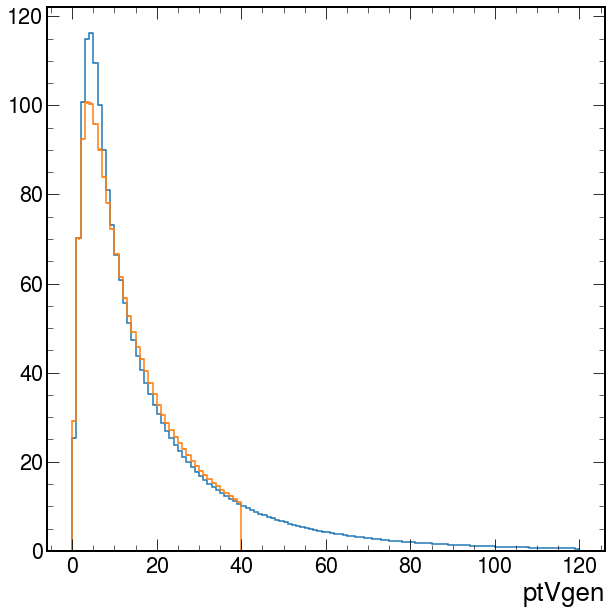

In [11]:
minnlohZ.project("ptVgen").plot(label="scetlib", binwnorm=True)
scetlibhZ_tot.project("pt").plot(label="minnlo")

In [12]:
minnlohZsel = minnlohZ[{"prefsr_lepton_eta_gen" : hist.sum, "prefsr_lepton_pt_gen" : hist.sum, "chargeVgen" : 0}]

In [ ]:
#ax = minnlohZ.axes["ptVgen"]
#np.add.reduceat(minnlohZ[0,0,:,0].values(), ax.index([0, 10, 20]))

In [ ]:
np.add.reduceat(minnlohZ[0,0,:,:].values(), ax.index(scetlibhZ_tot.axes["pt"].edges))

In [13]:
axm = minnlohZsel.axes["massVgen"]
axy = minnlohZsel.axes["absYVgen"]
axpt = minnlohZsel.axes["ptVgen"]

In [14]:
ipt = axpt.index(scetlibhZ_tot.axes["pt"].edges)
iy = axy.index(scetlibhZ_tot.axes["y"].edges)

In [ ]:
newh = np.add.reduceat(minnlohZ[:,:,:,0].values(), 
    ipt, axis=2
)

In [ ]:
newh = np.add.reduceat(newh, 
    (0,1), axis=1
)
np.sum(newh, axis=1, keepdims=True).shape

In [ ]:
hh.makeAbsHist(scetlibhZ_tot, "y")

In [15]:
# TODO: Make this nd
minnlocorr = minnlohZsel.project("ptVgen").copy()
scetlibcorr = minnlohZsel.project("ptVgen").copy()
max_pt_corr = scetlibcorr.axes["ptVgen"].index(scetlibhZ_tot.axes["pt"].edges[-1])
scetlibcorr[:max_pt_corr] = scetlibhZ_tot[0,0,...].project("pt").view()
corr = hh.divideHists(scetlibcorr, minnlocorr, cutoff=0.01)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0482c6fe50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

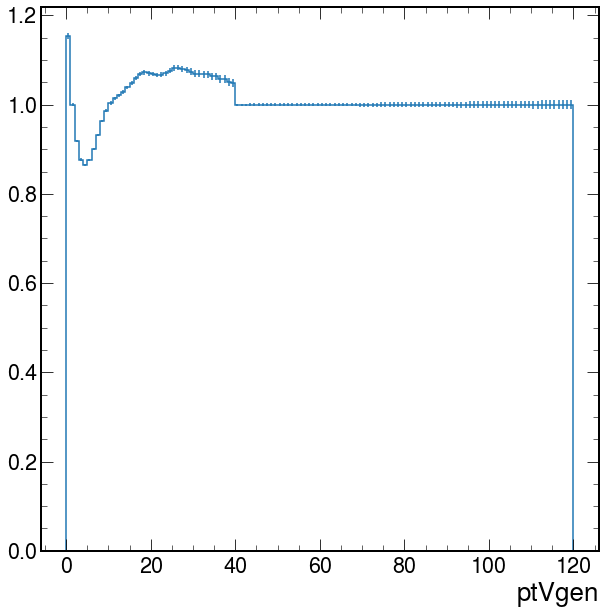

In [24]:
corr.plot()

In [39]:
corr

Hist(Variable(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.]), name='ptVgen', label='ptVgen'), storage=Weight()) # Sum: WeightedSum(value=121.257, variance=0.00427433) (WeightedSum(value=123.257, variance=0.00427704) with flow)

In [31]:
minnloScetlib = hh.multiplyHists(minnlohZsel, corr, transpose=False)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0481214b80>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

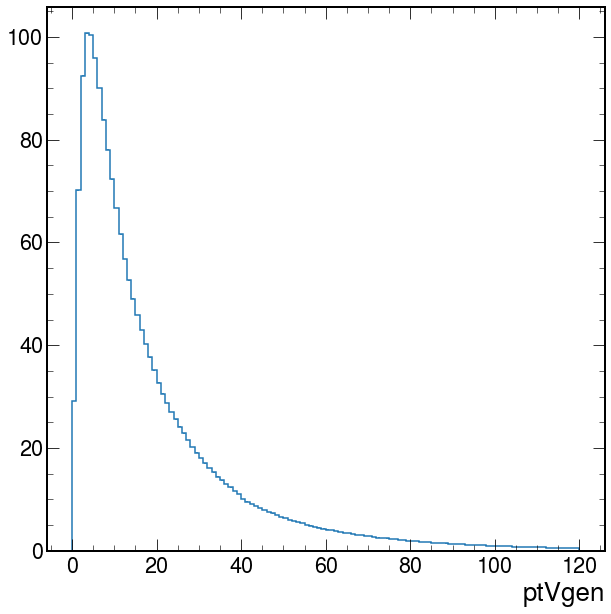

In [32]:
minnloScetlib.project("ptVgen").plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0480eb59f0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

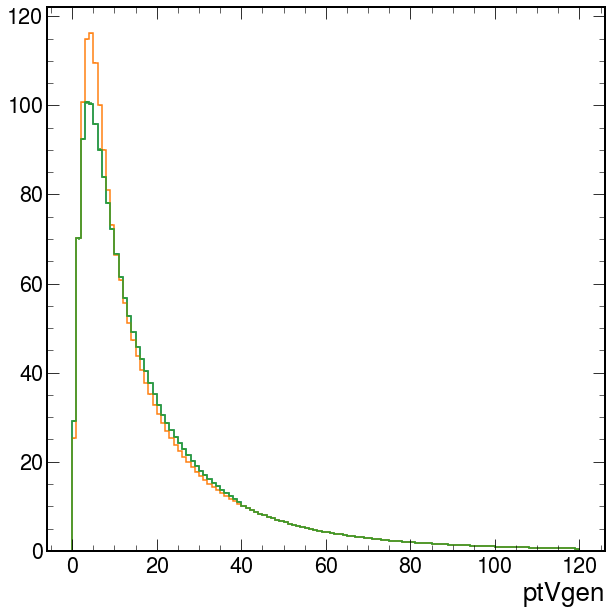

In [36]:
minnloScetlib.project("ptVgen").plot()
minnlohZsel.project("ptVgen").plot()
scetlibcorr.plot()

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([pdfPtV[:,0], pdfUp, pdfDown], colors=["black", "red", "blue"], labels=["nominal", "up", "down"], rrange=[0.95, 1.05], binwnorm=1.)

In [47]:
f = uproot.open("/eos/user/k/kelong/HistFiles/WGen/WmToMuNu_inclusive_MATRIX_RadISH_MatchEWParams_NNPDF31.root")
matrixRadish = f["wmmunu_matrix_radish/ptW_prefsr_mn"].to_hist()/1000

In [41]:
scetlibh_tot = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz", add_nonsing=True)
scetlibh_A4 = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_A4.npz", add_nonsing=True, flip_y_sign=True)
scetlibh_tot_s = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz", add_nonsing=False)

In [42]:
minnlocorr = minnloh.project("ptVgen").copy()
scetlibcorr = minnloh.project("ptVgen").copy()
scetlibcorr[...,:40] = scetlibh_tot.project("pt").view()
corrW = hh.divideHists(scetlibcorr, minnlocorr, cutoff=0.01)

In [49]:
corrW.shape

(120,)

In [ ]:
corr[30.j:40.j].axes["ptVgen"].centers

In [43]:
x = corr[20.j:40.j].axes["ptVgen"].centers
params = np.polyfit(y=corr[20.j:40.j].values(), x=x, deg = 2)
poly = np.poly1d(params)
xeval = corr[30.j:40.j].axes["ptVgen"].centers

In [44]:
corr_orig = corr.copy()
corr[30:40] = np.stack((poly(xeval), corr[30.j:40.j].variances()), axis=-1)

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0480e79780>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

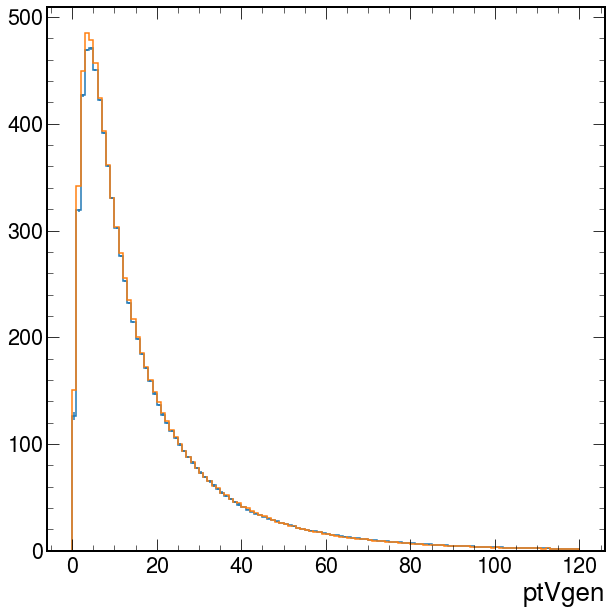

In [48]:
minnloScetlib = hh.multiplyHists(minnlocorr, corrW)
minnloScetlib.plot()
matrixRadish.plot()

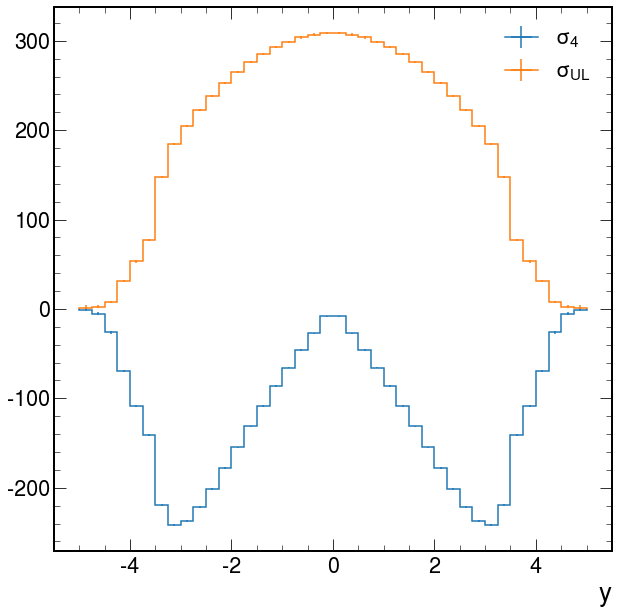

In [50]:
scetlibh_A4.project("y").plot(label=r"$\sigma_{4}$")
scetlibh_tot.project("y").plot(label=r"$\sigma_{\mathrm{UL}}$")
plt.legend()

In [51]:
scetlib_A4_coeff = hh.divideHists(scetlibh_A4, scetlibh_tot, cutoff=0.0001)
scetlib_A4_coeff_pt = hh.divideHists(scetlibh_A4.project("pt"), scetlibh_tot.project("pt"), cutoff=0.0001)

In [ ]:
scetlib_A4_coeff_pt.plot()

In [ ]:
scetlibh_A4.project("y").values()

In [ ]:
scetlibh_A4_nons.project("y").plot(label="singular")
scetlibh_A4.project("y").plot(label="nonsingular")
plt.title("A$_{4}$")
plt.legend()

In [ ]:
minnloh

In [ ]:
scetlibh_const

In [ ]:
scetlibh_A0.project("pt").plot(label="A$_{0}$")
(0.1*scetlibh_tot.project("pt")).plot(label="total")
minnloh.project("ptVgen").plot(label="minnlo")
plt.legend()

In [ ]:
scetlibhZ = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/inclusive_Z_pT.npz")

In [ ]:
scetlibhZ.project("pt").plot()
minnlohZ.project("ptVgen").plot(binwnorm=1.)

In [ ]:
scetlibh.project("pt").plot(label="W")
(100*scetlibhZ).project("pt").plot(label="Z")
plt.legend()

In [ ]:
minnloh.project("ptVgen").plot(binwnorm=1., label="MiNNLO")
scetlibh.project("pt").plot(label="SCETlib")

In [ ]:
scetlibhWpt = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-0.4-256-gbe3a9cb8/prod/scetlib_run/W/inclusive_Wm_pT.npz")

In [ ]:
scetlibhWpt[0,...].project("pt").plot(yerr=False)
minnloh.project("ptVgen").plot(binwnorm=1., label="MiNNLO")

In [ ]:
scetlibW_y_tot_s = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo.npz")
scetlibW_y_tot_nons = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo_nons.npz")
scetlibW_y_tot = scetlibW_y_tot_s + scetlibW_y_tot_nons

scetlibW_y_A4_s = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo_A4.npz")
scetlibW_y_A4_nons = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo_A4_nons.npz")
scetlibW_y_A4 = scetlibW_y_A4_s + scetlibW_y_A4_nons

#s = hist.tag.Slicer()
yax = scetlibW_y_A4.axes["y"]
scetlibW_y_A4[:,:,yax.index(0):,:] = scetlibW_y_A4[:,:,yax.index(0):,:].view()*-1

In [ ]:
scetlibW_y_tot = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz", add_nonsing=True)

In [ ]:
scetlibW_yabs_A4 = makeYAbsHist(scetlibW_y_A4)
scetlibW_yabs_tot = makeYAbsHist(scetlibW_y_tot)

In [ ]:
yax = scetlibW_y_A4.axes["y"]
axs = scetlibW_y_A4.axes

In [ ]:
scetlib_absy_A4_coeff = hh.divideHists(scetlibW_yabs_A4.project("y"), scetlibW_yabs_tot.project("y"))

In [ ]:
scetlibW_yabs_A4.project("y").plot()
scetlibW_yabs_tot.project("y").plot()
plt.xlim([0, 4.0])

In [ ]:
hh.divideHists(scetlibW_yabs_A4.project("y"), scetlibW_yabs_tot.project("y")).plot()
plt.xlim([0,4.0])

In [ ]:
scetlibW_y_A4.project("y").plot(label="$\sigma_{4}$")
scetlibW_y_tot.project("y").plot(label="Total")
plt.legend()
plt.xlim([-4.5, 4.5])
plt.title("SCETlib structure functions")

In [ ]:
minnlohel = minnlo["WminusmunuPostVFP"]["output"]["helicity_moments_scale"][{"muRfact" : 1.j, "muFfact" : 1.j, "chargeVgen" : -1.j}]

In [ ]:
minnlohel[...,:30,4.j]

In [ ]:
minnloCoeffs = theory_tools.moments_to_angular_coeffs(minnlohel[...,:30:hist.sum,:].project("absYVgen", "helicity"))

In [ ]:
minnloCoeffs[{"helicity" : 4.j}]
#scetlib_absy_A4_coeff.plot()

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([minnloCoeffs[{"helicity" : 4.j}], scetlib_absy_A4_coeff], colors=["red", "blue"], labels=["minnlo", "scetlib"], ylabel="A$_{4}$", rrange=[0.9, 1.1], rlabel="scetlib/minnlo")

In [ ]:
blah = np.expand_dims(blah, axis=tuple(range(blah.ndim, minnlohel.ndim-blah.ndim)))

In [ ]:
minnloByHel = minnlo["WminusmunuPostVFP"]["output"]["qcdScaleByHelicity"]*minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]/minnlo["WminusmunuPostVFP"]["weight_sum"]
minnloByHel

In [ ]:
import uproot

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0480b9a380>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

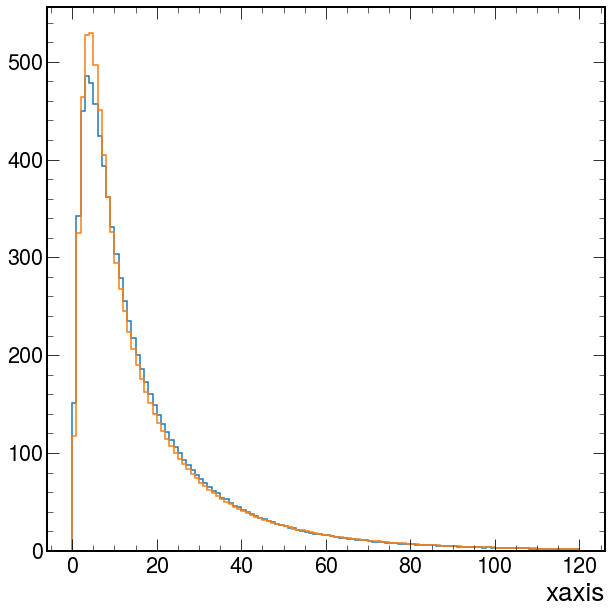

In [52]:
matrixRadish.plot()
minnloh.project("ptVgen").plot()

In [53]:
f = uproot.open("/eos/user/k/kelong/HistFiles/ZGen/ZToMuMu_MATRIX_RadISH_MatchEWParams_NNPDF31.root")

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0480b21870>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

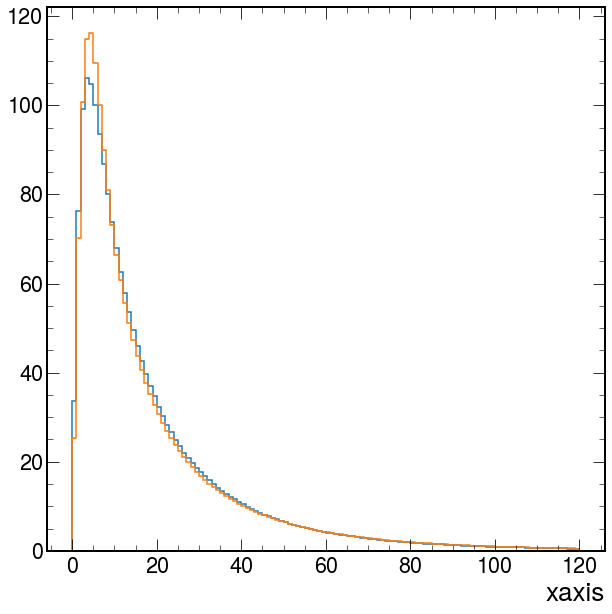

In [54]:
f["DYm50_matrix__radish/ptZ_lhe_mm"].to_hist().plot()
minnlohZ.project("ptVgen").plot()

In [59]:
dyturbof = np.load("/eos/user/k/kelong/HistFiles/WGen/DYTurbo/wm-13tev-cms-n3ll.npz")

In [60]:
ptax = hist.axis.Variable(dyturbof["bins"], name="pt")
dyturboh = hist.Hist(ptax, storage=hist.storage.Weight())
dyturboh[...] = np.stack((dyturbof["hist"], dyturbof["err"]), axis=-1)

In [61]:
dyturboMatch = matrixRadish.copy()
dyturboMatch[:40] = dyturboh.view()/1000

In [ ]:
dyturboMatch

In [74]:
scetlibMatch = matrixRadish.copy()
scetlibMatch[:40] = scetlibh_tot.project("pt").view()

In [77]:
minnloZbug

NameError: name 'minnloZbug' is not defined

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


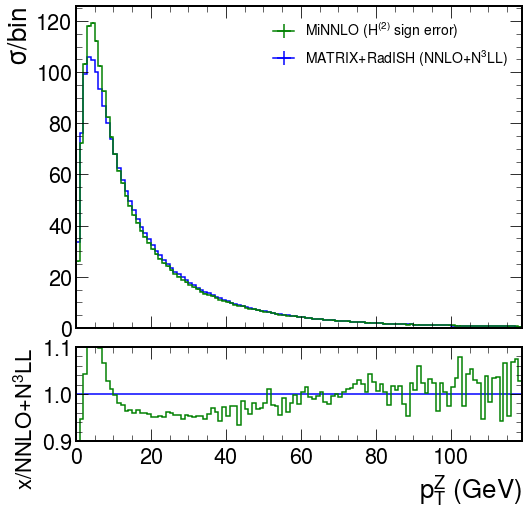

In [72]:
fig = plot_tools.makePlotWithRatioToRef([f["DYm50_matrix__radish/ptZ_lhe_mm"].to_hist(), minnlohZ.project("ptVgen")], colors=["blue", "green", ], labels=["MATRIX+RadISH (NNLO+N$^{3}$LL)", "MiNNLO (H$^{(2)}$ sign error)",], rrange=[0.9, 1.1], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1)


In [84]:
scetlibMatch.sum()

WeightedSum(value=8404.6, variance=54.1536)

In [85]:
minnlohW.sum()

WeightedSum(value=1182.21, variance=0.0574369)

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


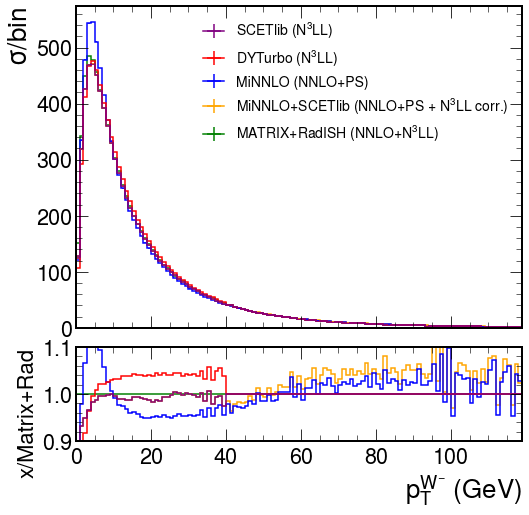

In [94]:
fig = plot_tools.makePlotWithRatioToRef([matrixRadish, minnloScetlib, minnlohW.project("ptVgen"), dyturboMatch, scetlibMatch],colors=["green", "orange", "blue", "red", "purple"], labels=["MATRIX+RadISH (NNLO+N$^{3}$LL)", "MiNNLO+SCETlib (NNLO+PS + N$^{3}$LL corr.)", "MiNNLO (NNLO+PS)", "DYTurbo (N$^{3}$LL)", "SCETlib (N$^{3}$LL)"], rrange=[0.9, 1.1], binwnorm=1., nlegcols=1, rlabel="x/Matrix+Rad", ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{W}^{-}}$ (GeV)")

#fig = plot_tools.makePlotWithRatioToRef([matrixRadish, minnloh.project("ptVgen"), dyturboMatch, scetlibMatch],colors=["green", "blue", "red", "purple"], labels=["MATRIX+RadISH (NNLO+N$^{3}$LL)", "MiNNLO (NNLO+PS)", "DYTurbo (N$^{3}$LL)", "SCETlib (N$^{3}$LL)"], rrange=[0.9, 1.1], binwnorm=1., nlegcols=1, rlabel="x/Matrix+Rad", ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{W}^{-}}$ (GeV)")



/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


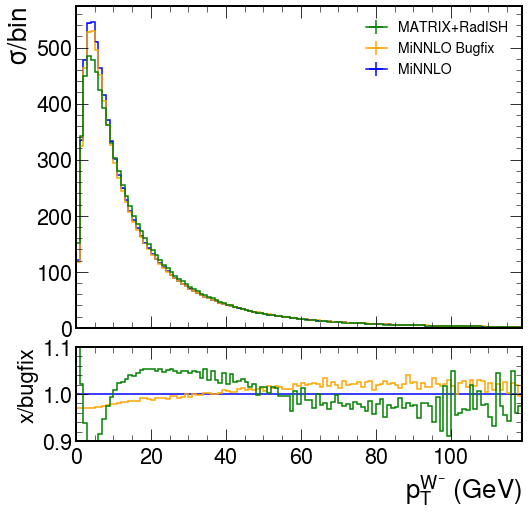

In [101]:
fig = plot_tools.makePlotWithRatioToRef([minnlohW.project("ptVgen"), minnloWbug.project("ptVgen"), matrixRadish],colors=["blue", "orange", "green"], labels=["MiNNLO", "MiNNLO Bugfix", "MATRIX+RadISH"], rrange=[0.9, 1.1], binwnorm=1., nlegcols=1, rlabel="x/bugfix", ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{W}^{-}}$ (GeV)")

